In [6]:
import csv
import tensorflow as tf
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import nltk
import string
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:

STOPWORDS = set(stopwords.words('english'))
vocab_size = 15000
embedding_dim = 512
max_length = 9000
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8
articles_train = []
labels_train = []
articles_valid = []
labels_valid = []
articles_test = []
labels_test = []



In [9]:
with open("foo.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        if(row!=[]):
          #print(row)
          labels_train.append(int(row[2]))
 
          article = row[1]
          for word in STOPWORDS:
              token = ' ' + word + ' '
              article = article.replace(token, ' ')
              article = article.replace(' ', ' ')
          articles_train.append(article)

with open("dev_split.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        if(row!=[]):
          #print(row)
          labels_valid.append(int(row[2]))
          article = row[1]
          for word in STOPWORDS:
              token = ' ' + word + ' '
              article = article.replace(token, ' ')
              article = article.replace(' ', ' ')
          articles_valid.append(article)

with open("test_split.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        if(row!=[]):
          #print(row)
          labels_test.append(int(row[2]))
          article = row[1]
          for word in STOPWORDS:
              token = ' ' + word + ' '
              article = article.replace(token, ' ')
              article = article.replace(' ', ' ')
          articles_test.append(article)



In [10]:
def clean_text(txt):
    """""
    cleans the input text in the following steps
    1- replace contractions
    2- removing punctuation
    3- spliting into words
    4- removing stopwords
    5- removing leftover punctuations
    """""
    txt = txt.replace("<synch>","")
    txt = txt.replace("<sync>","")
    txt = txt.replace("synch","")
    txt = txt.replace("sync","")
    
    contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
    def _get_contractions(contraction_dict):
        contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
        return contraction_dict, contraction_re

    def replace_contractions(text):
        contractions, contractions_re = _get_contractions(contraction_dict)
        def replace(match):
            return contractions[match.group(0)]
        return contractions_re.sub(replace, text)

    # replace contractions
    txt = replace_contractions(txt)
    
    #remove punctuations
    txt  = "".join([char for char in txt if char not in string.punctuation])
    txt = re.sub('[0-9]+', '', txt)
    
    
    # split into words
    words = word_tokenize(txt)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    
    # removing leftover punctuations
    words = [word for word in words if word.isalpha()]
    
    cleaned_text = ' '.join(words)
    return cleaned_text

In [4]:
def clean_text(text):
    """
    Applies some pre-processing on the given text.

    Steps :
    - Removing HTML tags
    - Removing punctuation
    - Lowering text
    """
    
    # remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # remove the characters [\], ['] and ["]
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)    
    text= re.sub("<synch>","",text)
    
    # convert text to lowercase
    text = text.strip().lower()
    
    # replace punctuation characters with spaces
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)

    return text



In [11]:
articles_train=[clean_text(x) for x in articles_train]
articles_test=[clean_text(x) for x in articles_test]
articles_valid=[clean_text(x) for x in articles_valid]

In [7]:
articles_train

['okay bout california yeah oh well big broad lot lot um um job opportunities states um pretty much big lot traffic um maybe violence rate bad news even though know wan na know going environment still watch know look see going daily basis sociology um two year degree liberal arts major sociology actually mta bus operator well since metro steady growing um dream job move company actually start classes supervisory next week um look promote within company good thing lot opportunities metro take classes pay tuition things nature thanks well actually hard right easy take advantage right look promote within know since already working good thing good go ahead take classes need interested go ahead move ladder soon possible mean sorry okay read take long walk hot bath meditate close eyes sometimes pretty much good see bus operator run circumstances situations got ta remain calm still remain professional time well look like goes mean comes experience know um something continuous basis usually so

In [7]:
s='<synch> yes pretty good alexandria'
print(clean_text(s))

yes pretty good alexandria


In [18]:
train_size = int(len(articles_train))

train_articles = articles_train
train_labels = labels_train

validation_articles = articles_valid
validation_labels = labels_valid

print(train_size)
print(len(train_articles))
print(len(train_labels))
print(len(validation_articles))
print(len(validation_labels))


107
107
107
35
35


In [46]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

In [24]:
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'good': 10,
 'know': 4,
 'laughter': 7,
 'like': 5,
 'really': 6,
 'uh': 3,
 'um': 2,
 'would': 9,
 'yeah': 8}

In [25]:
train_sequences = tokenizer.texts_to_sequences(train_articles)

In [26]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [27]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

35
(35, 9000)


In [31]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(1, activation='relu')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 512)         7680000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1024)              4198400   
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 12,403,713
Trainable params: 12,403,713
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
num_epochs = 10
history = model.fit(train_padded, np.array(train_labels), epochs=num_epochs, validation_data=(validation_padded, np.array(validation_labels)), verbose=2)

Epoch 1/10
4/4 - 13s - loss: 0.3767 - accuracy: 0.7570 - val_loss: 2.7190 - val_accuracy: 0.5714
Epoch 2/10
4/4 - 13s - loss: 1.0062 - accuracy: 0.8692 - val_loss: 10.0209 - val_accuracy: 0.3429
Epoch 3/10
4/4 - 13s - loss: 8.5723 - accuracy: 0.4393 - val_loss: 5.2886 - val_accuracy: 0.6571
Epoch 4/10
4/4 - 13s - loss: 4.3248 - accuracy: 0.7196 - val_loss: 5.2886 - val_accuracy: 0.6571
Epoch 5/10
4/4 - 13s - loss: 4.3248 - accuracy: 0.7196 - val_loss: 5.2886 - val_accuracy: 0.6571
Epoch 6/10
4/4 - 13s - loss: 4.3248 - accuracy: 0.7196 - val_loss: 5.2886 - val_accuracy: 0.6571
Epoch 7/10
4/4 - 13s - loss: 4.3248 - accuracy: 0.7196 - val_loss: 5.2886 - val_accuracy: 0.6571
Epoch 8/10
4/4 - 13s - loss: 4.3248 - accuracy: 0.7196 - val_loss: 5.2886 - val_accuracy: 0.6571
Epoch 9/10
4/4 - 13s - loss: 4.3248 - accuracy: 0.7196 - val_loss: 5.2886 - val_accuracy: 0.6571
Epoch 10/10
4/4 - 13s - loss: 4.3248 - accuracy: 0.7196 - val_loss: 5.2886 - val_accuracy: 0.6571


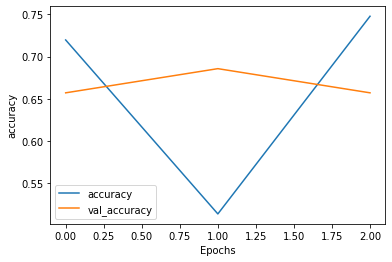

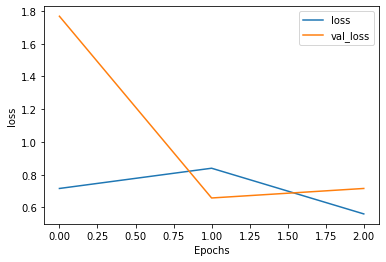

In [34]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [16]:
seq = tokenizer.texts_to_sequences(articles_test)
padded = pad_sequences(seq, maxlen=6000)

In [61]:
labels_test

[0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [51]:
pred = model.predict(padded)

In [60]:
print(pred)

[[0.59821737]
 [0.5984443 ]
 [0.6008392 ]
 [0.5992068 ]
 [0.60564506]
 [0.5929282 ]
 [0.59492916]
 [0.6017901 ]
 [0.59822774]
 [0.5952843 ]
 [0.60268253]
 [0.58954155]
 [0.5998987 ]
 [0.5988245 ]
 [0.59972036]
 [0.6036567 ]
 [0.60075605]
 [0.6014853 ]
 [0.59876496]
 [0.6088017 ]
 [0.60129255]
 [0.600526  ]
 [0.59504724]
 [0.6028761 ]
 [0.58107245]
 [0.5892339 ]
 [0.5988624 ]
 [0.59742415]
 [0.5973041 ]
 [0.59785706]
 [0.5974904 ]
 [0.5985391 ]
 [0.59547424]
 [0.5985277 ]
 [0.60448366]
 [0.5963223 ]
 [0.6009586 ]
 [0.5978711 ]
 [0.60231555]
 [0.6036257 ]
 [0.5984778 ]
 [0.6019343 ]
 [0.60425574]
 [0.60610807]
 [0.5872573 ]
 [0.6050183 ]
 [0.6093499 ]]


In [57]:
test_out=[]
for x in pred:
  if(x<0.5):
    test_out.append(0)
  else:
    test_out.append(1)

In [58]:
a=0

for x in range(0,len(test_out)):
  if(test_out[x]==labels_test[x]):
    a=a+1
    print(test_out[x])


1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [59]:
a/len(labels_test)

0.2978723404255319

# Using GLOVE embeddings

In [1]:
!wget http://nlp.stanford.edu/data/glove.42B.300d.zip

--2021-04-08 11:35:54--  http://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.42B.300d.zip [following]
--2021-04-08 11:35:54--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip [following]
--2021-04-08 11:35:55--  http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]
Sav

In [2]:
!unzip glove*.zip

Archive:  glove.42B.300d.zip
  inflating: glove.42B.300d.txt      


In [12]:
from tensorflow.keras.preprocessing import text,sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout

In [13]:
embedding_vectors = {}
# with open('/kaggle/input/glove6b100d/glove.6B.100d.txt','r',encoding='utf-8') as file:
with open('glove.42B.300d.txt','r',encoding='utf-8') as file:
    for row in file:
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vectors[word] = weights
print(f"Size of vocabulary in GloVe: {len(embedding_vectors)}")

Size of vocabulary in GloVe: 1917494


In [14]:
max_words = 10000
tokenizer = text.Tokenizer(num_words = max_words)
# create the vocabulary by fitting on x_train text
tokenizer.fit_on_texts(articles_train)
# generate the sequence of tokens
xtrain_seq = tokenizer.texts_to_sequences(articles_train)
xtest_seq = tokenizer.texts_to_sequences(articles_valid)

# pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_length)
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_length)
word_index = tokenizer.word_index


In [15]:
emb_dim = 300
if max_words is not None: 
    vocab_len = max_words 
else:
    vocab_len = len(word_index)+1
embedding_matrix = np.zeros((vocab_len, emb_dim))
oov_count = 0
oov_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            oov_count += 1 
            oov_words.append(word)
#print some of the out of vocabulary words
print(f'Some out of valubulary words: {oov_words[0:5]}')

Some out of valubulary words: ['scrubbedentry', 'notve', 'wellbehaved', 'naitivity', 'thatve']


In [16]:
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
lstm_model.add(LSTM(128, return_sequences=False))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation = 'sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 3,219,777
Trainable params: 219,777
Non-trainable params: 3,000,000
_________________________________________________________________
None


In [19]:
epochs  = 5
history = lstm_model.fit(xtrain_pad, np.asarray(labels_train), validation_data=(xtest_pad, np.array(validation_labels)), epochs = epochs)

Epoch 1/5
4/4 [==============================] - 35s 664ms/step - loss: 0.6508 - accuracy: 0.5846 - val_loss: 0.7740 - val_accuracy: 0.6571
Epoch 2/5
4/4 [==============================] - 2s 535ms/step - loss: 0.5626 - accuracy: 0.7493 - val_loss: 0.7145 - val_accuracy: 0.6571
Epoch 3/5
4/4 [==============================] - 2s 519ms/step - loss: 0.5440 - accuracy: 0.7410 - val_loss: 0.6405 - val_accuracy: 0.6571
Epoch 4/5
4/4 [==============================] - 2s 530ms/step - loss: 0.5641 - accuracy: 0.7403 - val_loss: 0.6385 - val_accuracy: 0.6571
Epoch 5/5
4/4 [==============================] - 2s 525ms/step - loss: 0.5600 - accuracy: 0.7635 - val_loss: 0.6442 - val_accuracy: 0.6571


Text(0.5, 1.0, 'Accuracy')

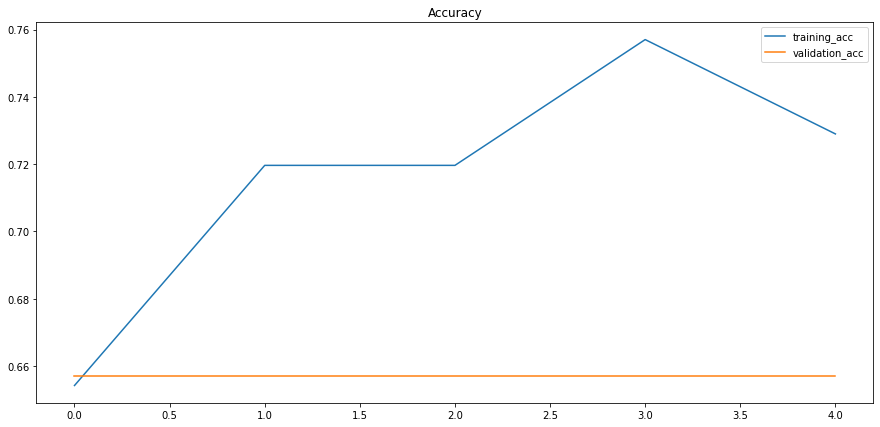

In [20]:
plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['accuracy'])
plt.plot(range(epochs), history.history['val_accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')
